In [36]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

inputs_path = os.path.join(os.path.dirname(os.getcwd()), "data", "inputs")

plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 1

warnings.simplefilter(action='ignore', category=FutureWarning)

In [37]:
# load data
data = pd.read_csv(os.path.join(inputs_path, "sample", "etfs.csv"), sep=";")
data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d")
data = data.set_index("date")

# resample data
data = data.resample("B").last()

# calculate log returns
returns = np.log(data / data.shift(1))

returns.tail()

,SPY,IWM,EEM,TLT,USO,GLD,XLF,XLB,XLK,XLV,...,XLU,XLY,XLP,XLE,VIX,AGG,DBC,HYG,LQD,UUP
date,,,,,,,,,,,,,,,,,,,,,
2023-11-16,0.001222,-0.016298,-0.009620,0.012350,-0.047214,0.011223,0.004028,0.003000,0.004980,0.004289,...,0.005326,-0.010306,-0.012426,-0.019696,0.009825,0.005485,-0.024269,0.001341,0.008200,0.000679
2023-11-17,0.001243,0.013609,0.001271,0.004676,0.038910,-0.000109,0.005155,0.001870,-0.002077,-0.002025,...,0.002733,0.006663,-0.001294,0.020760,-0.036989,0.001997,0.014298,0.002276,0.002878,-0.005446
2023-11-20,0.007668,0.005816,0.012372,0.006090,0.021672,-0.001635,0.003991,0.001743,0.014393,0.006063,...,-0.003055,0.005132,-0.000720,0.001416,-0.028668,0.001574,0.012448,0.001069,0.004015,-0.003076
2023-11-21,-0.002182,-0.012965,-0.006293,-0.000442,0.003176,0.010740,-0.000569,0.003848,-0.008121,0.006027,...,0.002091,-0.002563,0.003020,-0.002243,-0.004484,0.001048,0.005757,0.001335,0.000286,0.001027
2023-11-22,0.003875,0.006251,-0.002022,0.003528,-0.012766,-0.004271,0.003977,0.000619,0.004448,0.004765,...,0.004809,0.003039,0.007153,-0.000473,-0.033514,0.000942,-0.008647,0.001733,0.003998,0.003414


<Axes: xlabel='date'>

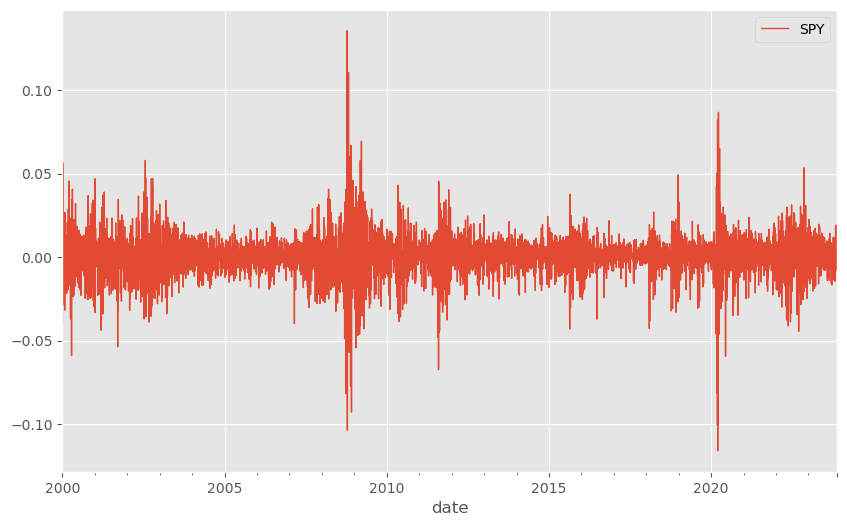

In [38]:
returns[["SPY"]].plot(figsize=(10, 6))

<Axes: xlabel='date'>

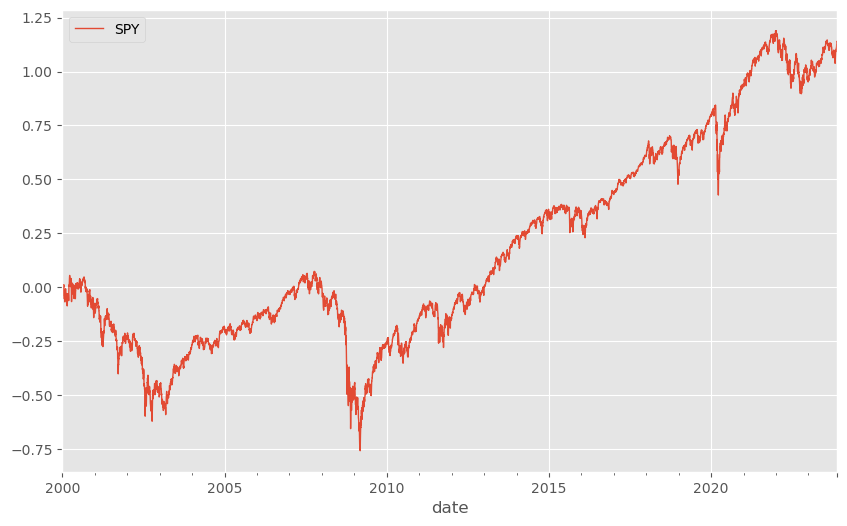

In [39]:
returns[["SPY"]].cumsum().plot(figsize=(10, 6))

In [85]:
target = "SPY"

ks = [0, 1, 2]
S_k = [8, 16, 32]
L_k = [24, 48, 96]
sw = 63
pw = 252
weights = [1/3, 1/3, 1/3]

intermediate_signals = []
for k in ks:

    # compute short and long-term ewma
    short_term_signal = data[target].ewm(halflife=S_k[k]).mean()
    long_term_signal = data[target].ewm(halflife=L_k[k]).mean()

    # compute diff
    signal_diff = short_term_signal - long_term_signal

    # standardize diff
    standardized_diff = signal_diff / data[target].rolling(window=sw).std()

    # standardize (standardized_diff)
    standardized_diff = standardized_diff / standardized_diff.rolling(window=pw).std()

    intermediate_signal = (standardized_diff * np.exp(-0.25 * (standardized_diff ** 2))) / 0.89
    intermediate_signals.append(intermediate_signal)

for i, w in enumerate(weights):
    if i == 0:
        signal = w * intermediate_signals[i]
    else:
        signal += w * intermediate_signals[i]

<Axes: xlabel='date'>

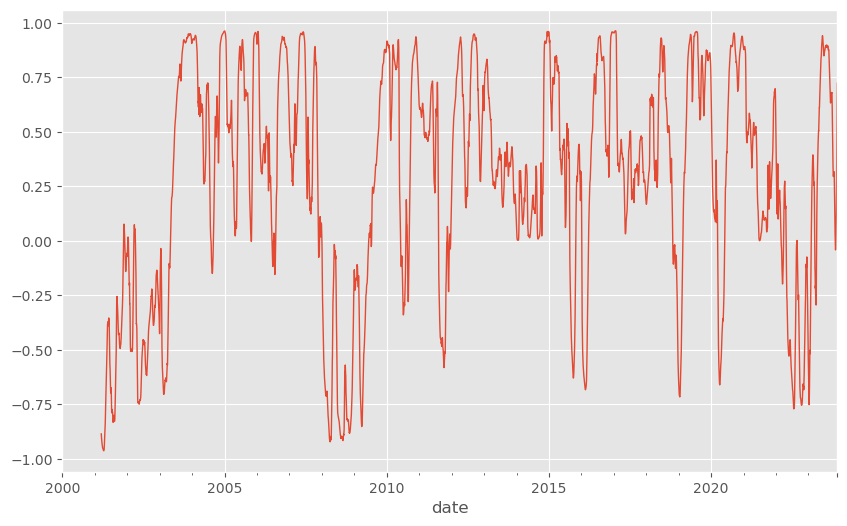

In [86]:
signal.plot(figsize=(10, 6))

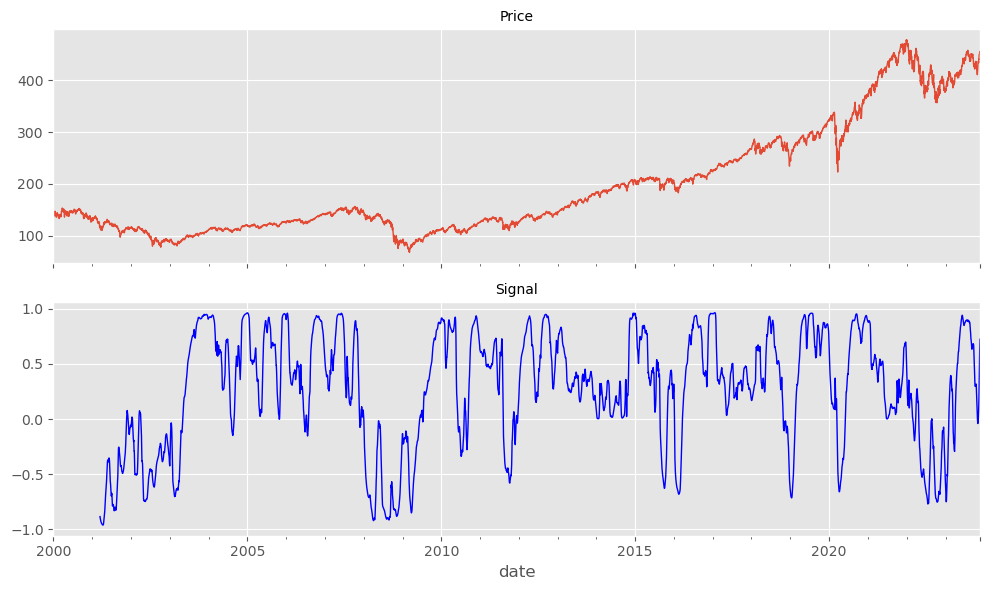

In [95]:
signal_df = pd.DataFrame(signal)
signal_df.rename(columns={target: "signal"}, inplace=True)
price_signal_df = pd.concat([data[target], signal_df], axis=1)

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

price_signal_df[target].plot(ax=ax[0])
ax[0].set_title("Price", size=10)

price_signal_df["signal"].plot(ax=ax[1], color="b")
ax[1].set_title("Signal", size=10)

plt.tight_layout()
plt.show()